In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
iris = datasets.load_iris()
X = iris.data.astype(np.float32)
Y = iris.target
N = Y.size
Y2 = keras.utils.to_categorical(Y, num_classes=3)

index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = Y[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = Y[index[index % 2 == 0]]

In [4]:
class MyKerasClassifier(KerasClassifier):
    
    def predict(self, x, **kwargs):
        pred = self.model.predict(x)
        y2_pred = np.argmax(pred, 1)
        return self.classes_[y2_pred]
    
    def predict_proba(self, x, **kwargs):
        probs = self.model.predict(x)
        
        # check if binary classification
        if probs.shape[1] == 1:
            # first column is probability of class 0 and second is of class 1
            probs = np.hstack([1 - probs, probs])
        return probs

In [5]:
def make_model(lam=0.001, flag_sum=False):
    K.clear_session()
    inputLayer = Input(shape=(4,))
    encoded = Dense(4000, activation='elu')(inputLayer)
    encoded = Dense(3000, activation='elu')(encoded)
    encoded = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(lam))(encoded)
    
    model = Model(inputLayer, encoded)
    sgd = SGD(lr=0.01, decay=1.0e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    if flag_sum:
        model.summary()
    return model

In [6]:
'''
lambda=0.001（default）
'''
classifier = MyKerasClassifier(make_model, batch_size=75, epochs=200, verbose=0, flag_sum=True)
#classifier = KerasClassifier(make_model, batch_size=75, epochs=200)
classifier.fit(xtrain, ytrain)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4000)              20000     
_________________________________________________________________
dense_2 (Dense)              (None, 3000)              12003000  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9003      
Total params: 12,032,003
Trainable params: 12,032,003
Non-trainable params: 0
_________________________________________________________________


In [7]:
classifier.predict_proba(xtrain)
classifier.predict(xtrain)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
dir(classifier)
classifier.classes_

array([0, 1, 2])

In [9]:
classifier.score(xtrain, ytrain)

0.9866666793823242

In [10]:
classifier.score(xtest, yans)

0.9733333587646484

In [11]:
y_pred = classifier.predict(xtrain)
print(y_pred.shape)

(75,)


In [12]:
f1_score(ytrain, y_pred, average='micro')

0.9866666666666668

In [13]:
ytrain

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [15]:
print(classification_report(ytrain, y_pred))
print(classifier.score(xtrain, ytrain))
f1_score(ytrain, y_pred, average='macro')

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        25
          1       1.00      0.96      0.98        25
          2       0.96      1.00      0.98        25

avg / total       0.99      0.99      0.99        75

0.9866666793823242


0.9866613311991462

In [16]:
scorer = make_scorer(f1_score, average='micro')
scorer

make_scorer(f1_score, average=micro)

In [17]:
classifier.model

In [18]:
scorer(classifier, xtrain, ytrain)

0.9866666666666668

In [19]:
classifier.get_params()

{'batch_size': 75,
 'build_fn': <function __main__.make_model>,
 'epochs': 200,
 'flag_sum': True,
 'verbose': 0}

In [20]:
from sklearn.model_selection import validation_curve, StratifiedShuffleSplit
param_range = np.logspace(-6, 2, 15)
param_range

array([1.00000000e-06, 3.72759372e-06, 1.38949549e-05, 5.17947468e-05,
       1.93069773e-04, 7.19685673e-04, 2.68269580e-03, 1.00000000e-02,
       3.72759372e-02, 1.38949549e-01, 5.17947468e-01, 1.93069773e+00,
       7.19685673e+00, 2.68269580e+01, 1.00000000e+02])

In [21]:
cv = StratifiedShuffleSplit(3, test_size=0.5)

In [22]:
classifier = MyKerasClassifier(make_model, batch_size=75, epochs=200, verbose=0, flag_sum=False)

# train_scores, test_scores = validation_curve(
#     classifier, X, Y, param_name="lam", param_range=param_range,
#     cv=10, scoring="f1_micro", n_jobs=1)
train_scores, test_scores = validation_curve(
    classifier, X, Y, param_name="lam", param_range=param_range,
    cv=cv, scoring=scorer, n_jobs=1)

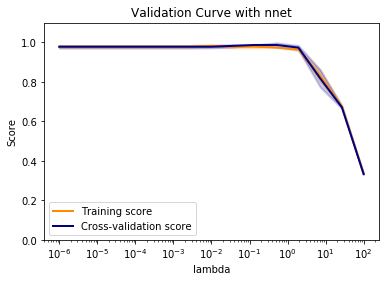

In [23]:
train_scores
train_scores.shape

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean
train_scores_std = np.std(train_scores, axis=1)
train_scores_std
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean
test_scores_std = np.std(test_scores, axis=1)
test_scores_std

plt.title("Validation Curve with nnet")
plt.xlabel("lambda")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")